# Set up

In [1]:
import os
import sys
import json
import subprocess
import operator
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Load post-processes data from more general database (`mutants_docked_geometry-interactions.db`) of peptide Euler angles and peptide radial profiles.

See [this](pore_geometry_analysis.ipynb) notebook to check how the database is processed.

In [2]:
folder = 'data'
filename = 'mutants_docked_geometry-interactions_post-processed.json'
path   = os.path.join(folder, filename)

with open(path, 'r') as fp:
    S_mutants = json.load(fp)

In [3]:
mutant_names = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

# Plot raw data of pore dimensions  

From the above collection of measurements from all docking model we plot their pore dimensions, as given by the _minimum radius_ and the _lenght_ of their van der Waals profiles.

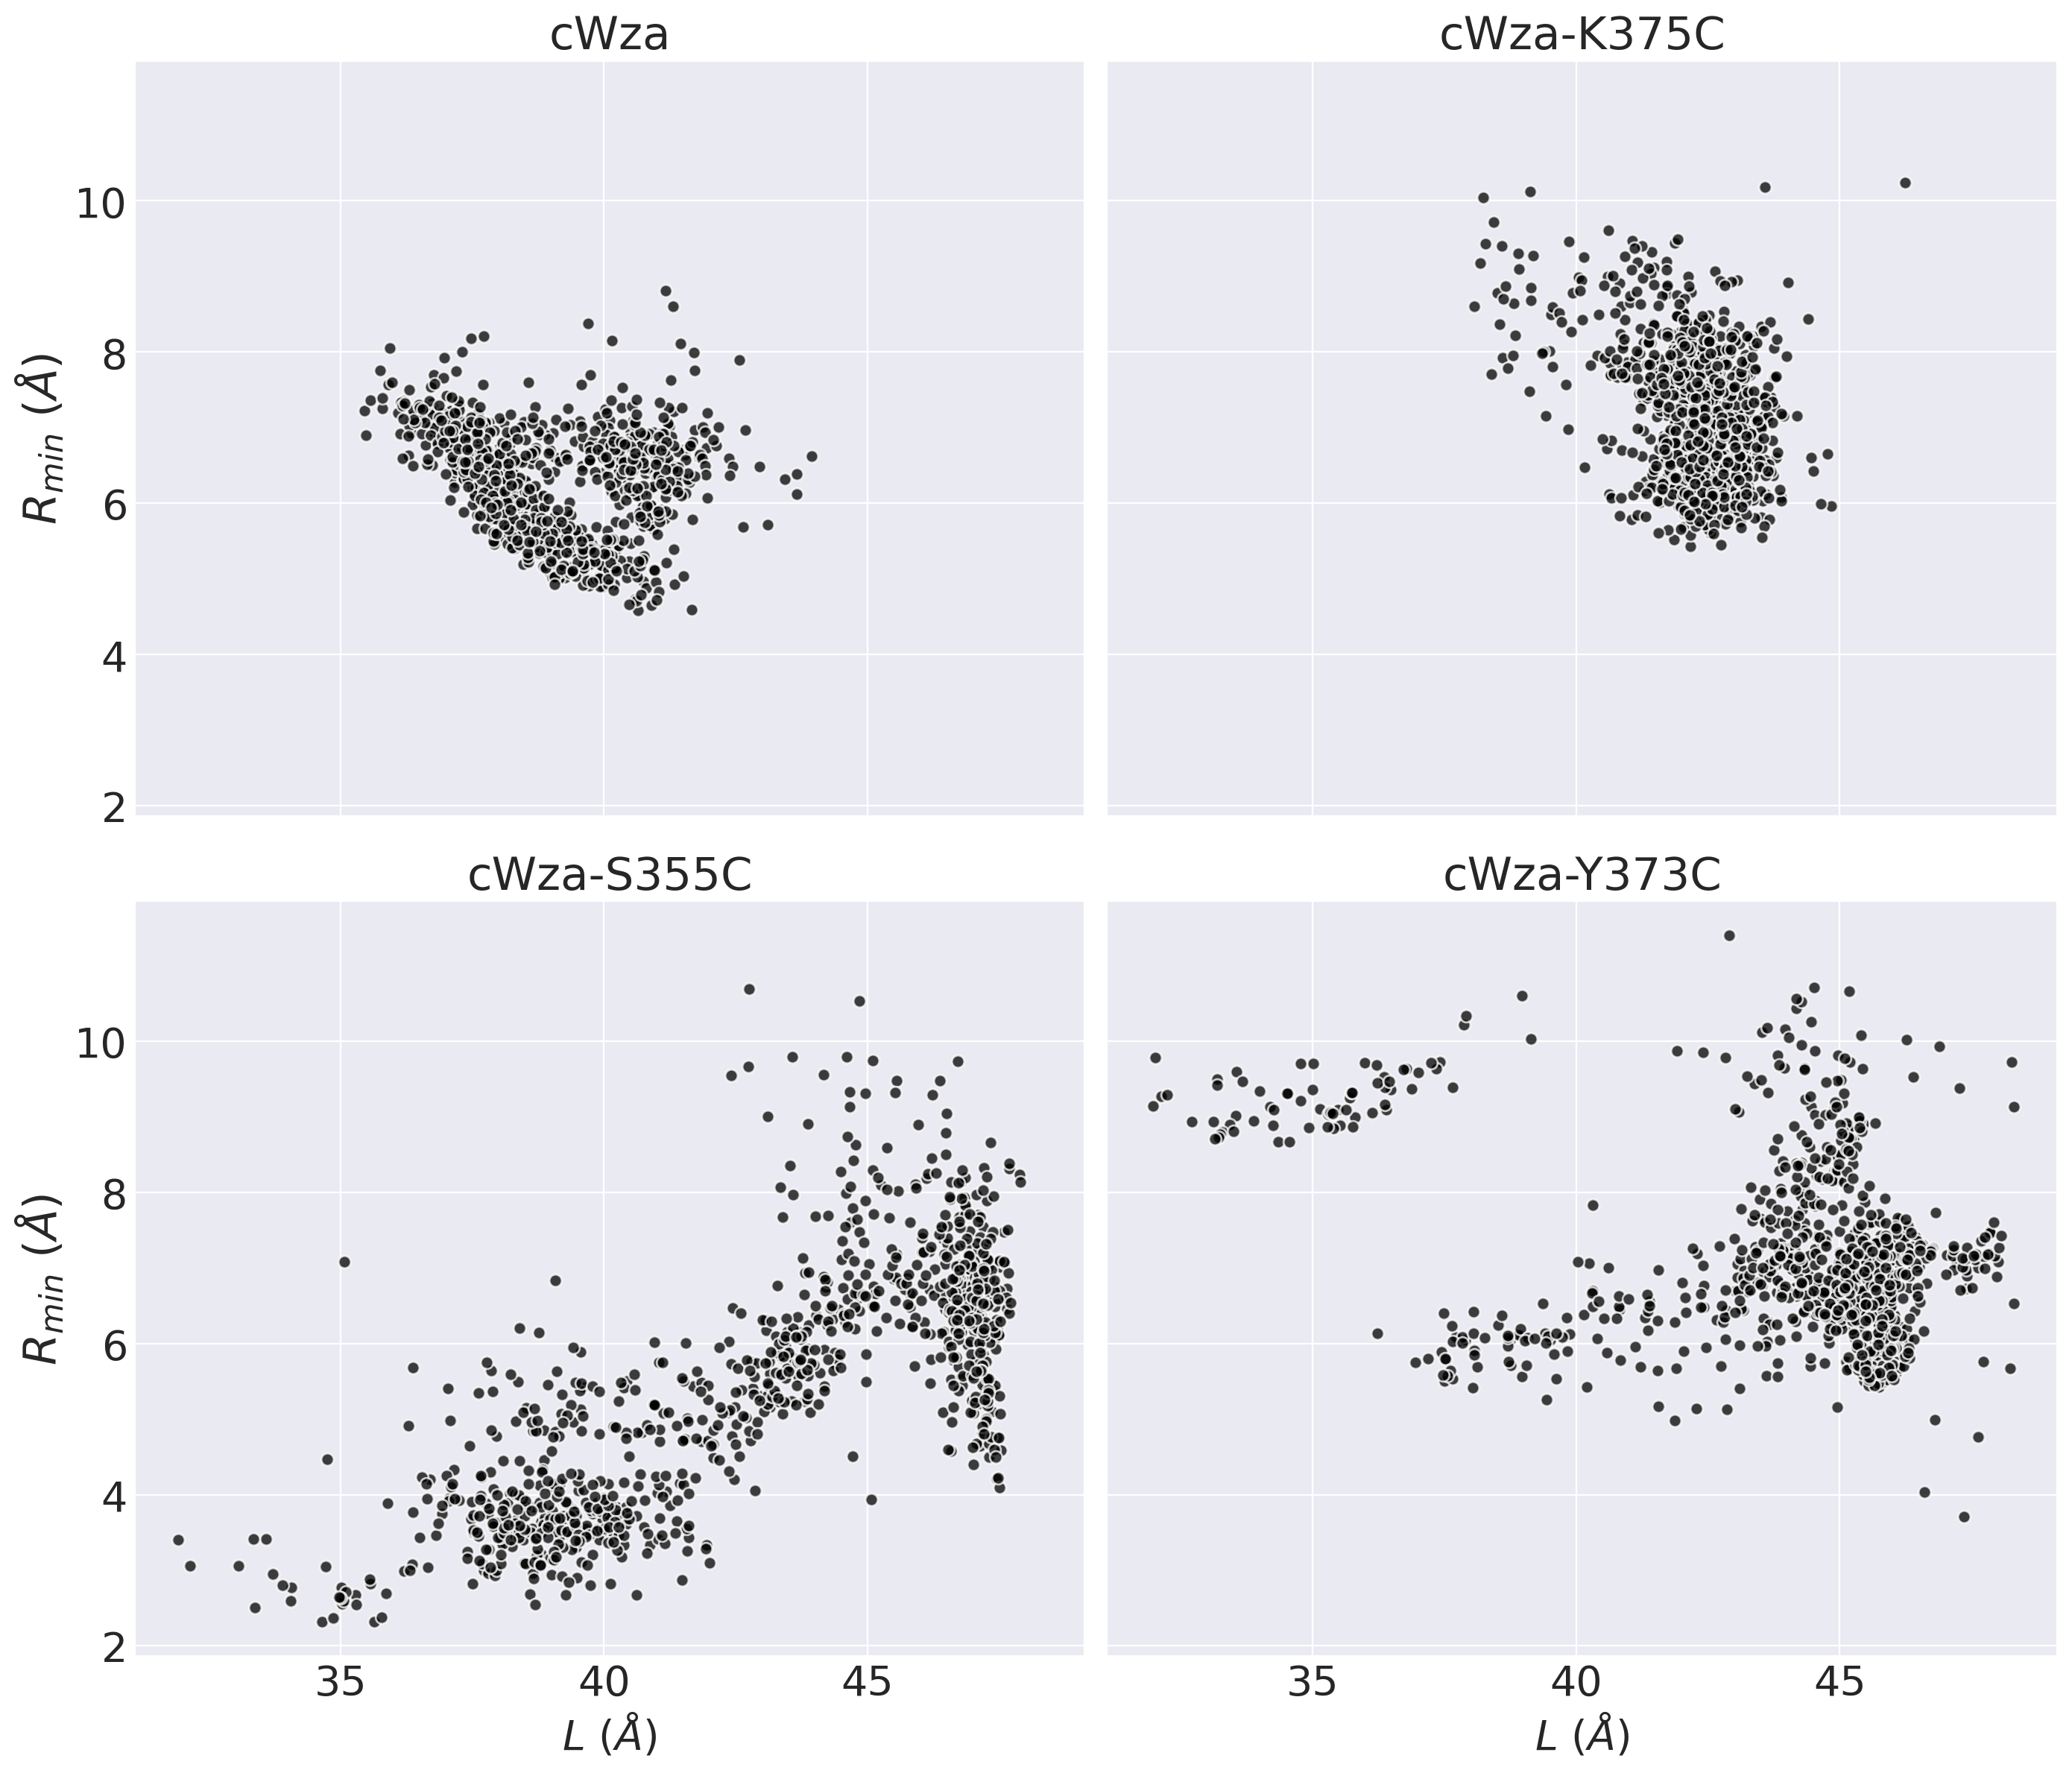

In [4]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2,2, figsize=(14, 12),dpi=200,sharex=True,sharey=True)
n_mutants = len(mutant_names)
import matplotlib

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

for i in range(n_mutants):
    
    # Select metric types to plot
    mutant = mutant_names[i]
    key11, key12 = 'vdw metrics','length'
    key21, key22 = 'vdw metrics','min'
    
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    
    # Plot raw data as scatter plot
    axes[mutant].scatter(X1, X2, color="black", edgecolor='white', alpha=0.75)
    
    # Customise plot
    axes[mutant].set_title(mutant, fontsize=22)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=20)
    axes[mutant].set_ylabel(l2,fontsize=22)
    
# fig.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.show()

# Estimate PDFs and find local maxima (peaks)

Base functions

ORIGINAL VERSION

In [5]:
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

def density_estimation(x_coords, y_coords):
    """
    Return a 2D grid and its PDF values estimated from input coordinates (sample data)
    
    Parameters
    ----------
    x_coords : sample 1D array (n, 1)
        
    y_coords : sampple 1D array (n, 1)
    
    Returns
    -------
        X : meshgrid ndarray 
            x-coords regular grid
            
        Y : meshgrid ndarray 
            y-coords regular grid
            
        Z : meshgrid ndarray
            density values over XY grid
        
    """
    # make a regular 2D grid
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    X, Y = np.mgrid[x_min:x_max:400j, y_min:y_max:400j]                                               
    positions = np.vstack([X.ravel(), Y.ravel()]) # array of 2D arrays
    
    # estimate PDF from input coordinate data
    values = np.vstack([x_coords, y_coords])                                                                        
    kernel = gaussian_kde(values)
    
    # return estimated PDF values for regular grid
    Z = np.reshape(kernel(positions).T, X.shape)
    
    return X, Y, Z

def find_maxima(X1, X2):
    """
    Return coordinates of maximum PDF values estimated from input coordinates (sample data)
        
    Parameters
    ----------
    X1 : 1D array (n, 1)
        sample x-coords
        
    X2 : 1D array (n, 1)
        sample y-coords
    
    Returns
    -------
    maxima : list of 2d arrays
        peaks' coordinates of estimated PDF from sample data
    """
    # obtain 2D grid and their PDF values
    X,Y,Z = list(density_estimation(X1, X2))
    
    # locate PDF peaks by minimum pixel distance and fraction height glob-max
    coordinates = peak_local_max(Z, threshold_rel=0.5, min_distance=20)
    
    # find peaks coordinates
    maxima = []
    for k in range(len(coordinates)):
        idx_0,idx_1 = coordinates[k]
        x_max, y_max = X[idx_0][0], Y[idx_0][idx_1]
        maxima.append((x_max, y_max))
        
    return maxima

MODIFIED VERSION

In [6]:
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

def density_estimation(x_coords, y_coords):
    """
    Return a 2D grid and its PDF values estimated from input coordinates (sample data)
    
    Parameters
    ----------
    x_coords : sample 1D array (n, 1)
        
    y_coords : sampple 1D array (n, 1)
    
    Returns
    -------
        X : meshgrid ndarray 
            x-coords regular grid
            
        Y : meshgrid ndarray 
            y-coords regular grid
            
        Z : meshgrid ndarray
            density values over XY grid
        
    """
    # make a regular 2D grid
    offset_x = 5; offset_y = 2 # to get closed contour lines
    x_min, x_max = min(x_coords)-offset_x, max(x_coords)+offset_x
    y_min, y_max = min(y_coords)-offset_y, max(y_coords)+offset_y
    X, Y = np.mgrid[x_min:x_max:400j, y_min:y_max:400j]                                               
    positions = np.vstack([X.ravel(), Y.ravel()]) # array of 2D arrays
    
    # estimate PDF from input coordinate data
    values = np.vstack([x_coords, y_coords])                                                                        
    kernel = gaussian_kde(values)
    
    # return estimated PDF values for regular grid
    Z = np.reshape(kernel(positions).T, X.shape)
    
    return X, Y, Z

def find_maxima(X1, X2):
    """
    Return coordinates of maximum PDF values estimated from input coordinates (sample data)
        
    Parameters
    ----------
    X1 : 1D array (n, 1)
        sample x-coords
        
    X2 : 1D array (n, 1)
        sample y-coords
    
    Returns
    -------
    maxima : list of 2d arrays
        peaks' coordinates of estimated PDF from sample data
    """
    # obtain 2D grid and their PDF values
    X,Y,Z = list(density_estimation(X1, X2))
    
    # locate PDF peaks by minimum pixel distance and fraction height glob-max
    coordinates = peak_local_max(Z, threshold_rel=0.5, min_distance=20)
    
    # find peaks coordinates
    maxima = []
    for k in range(len(coordinates)):
        idx_0,idx_1 = coordinates[k]
        x_max, y_max = X[idx_0][0], Y[idx_0][idx_1]
        maxima.append((x_max, y_max))
        
    return maxima

Plot PDF and its peaks for all cWza-mutant sequences

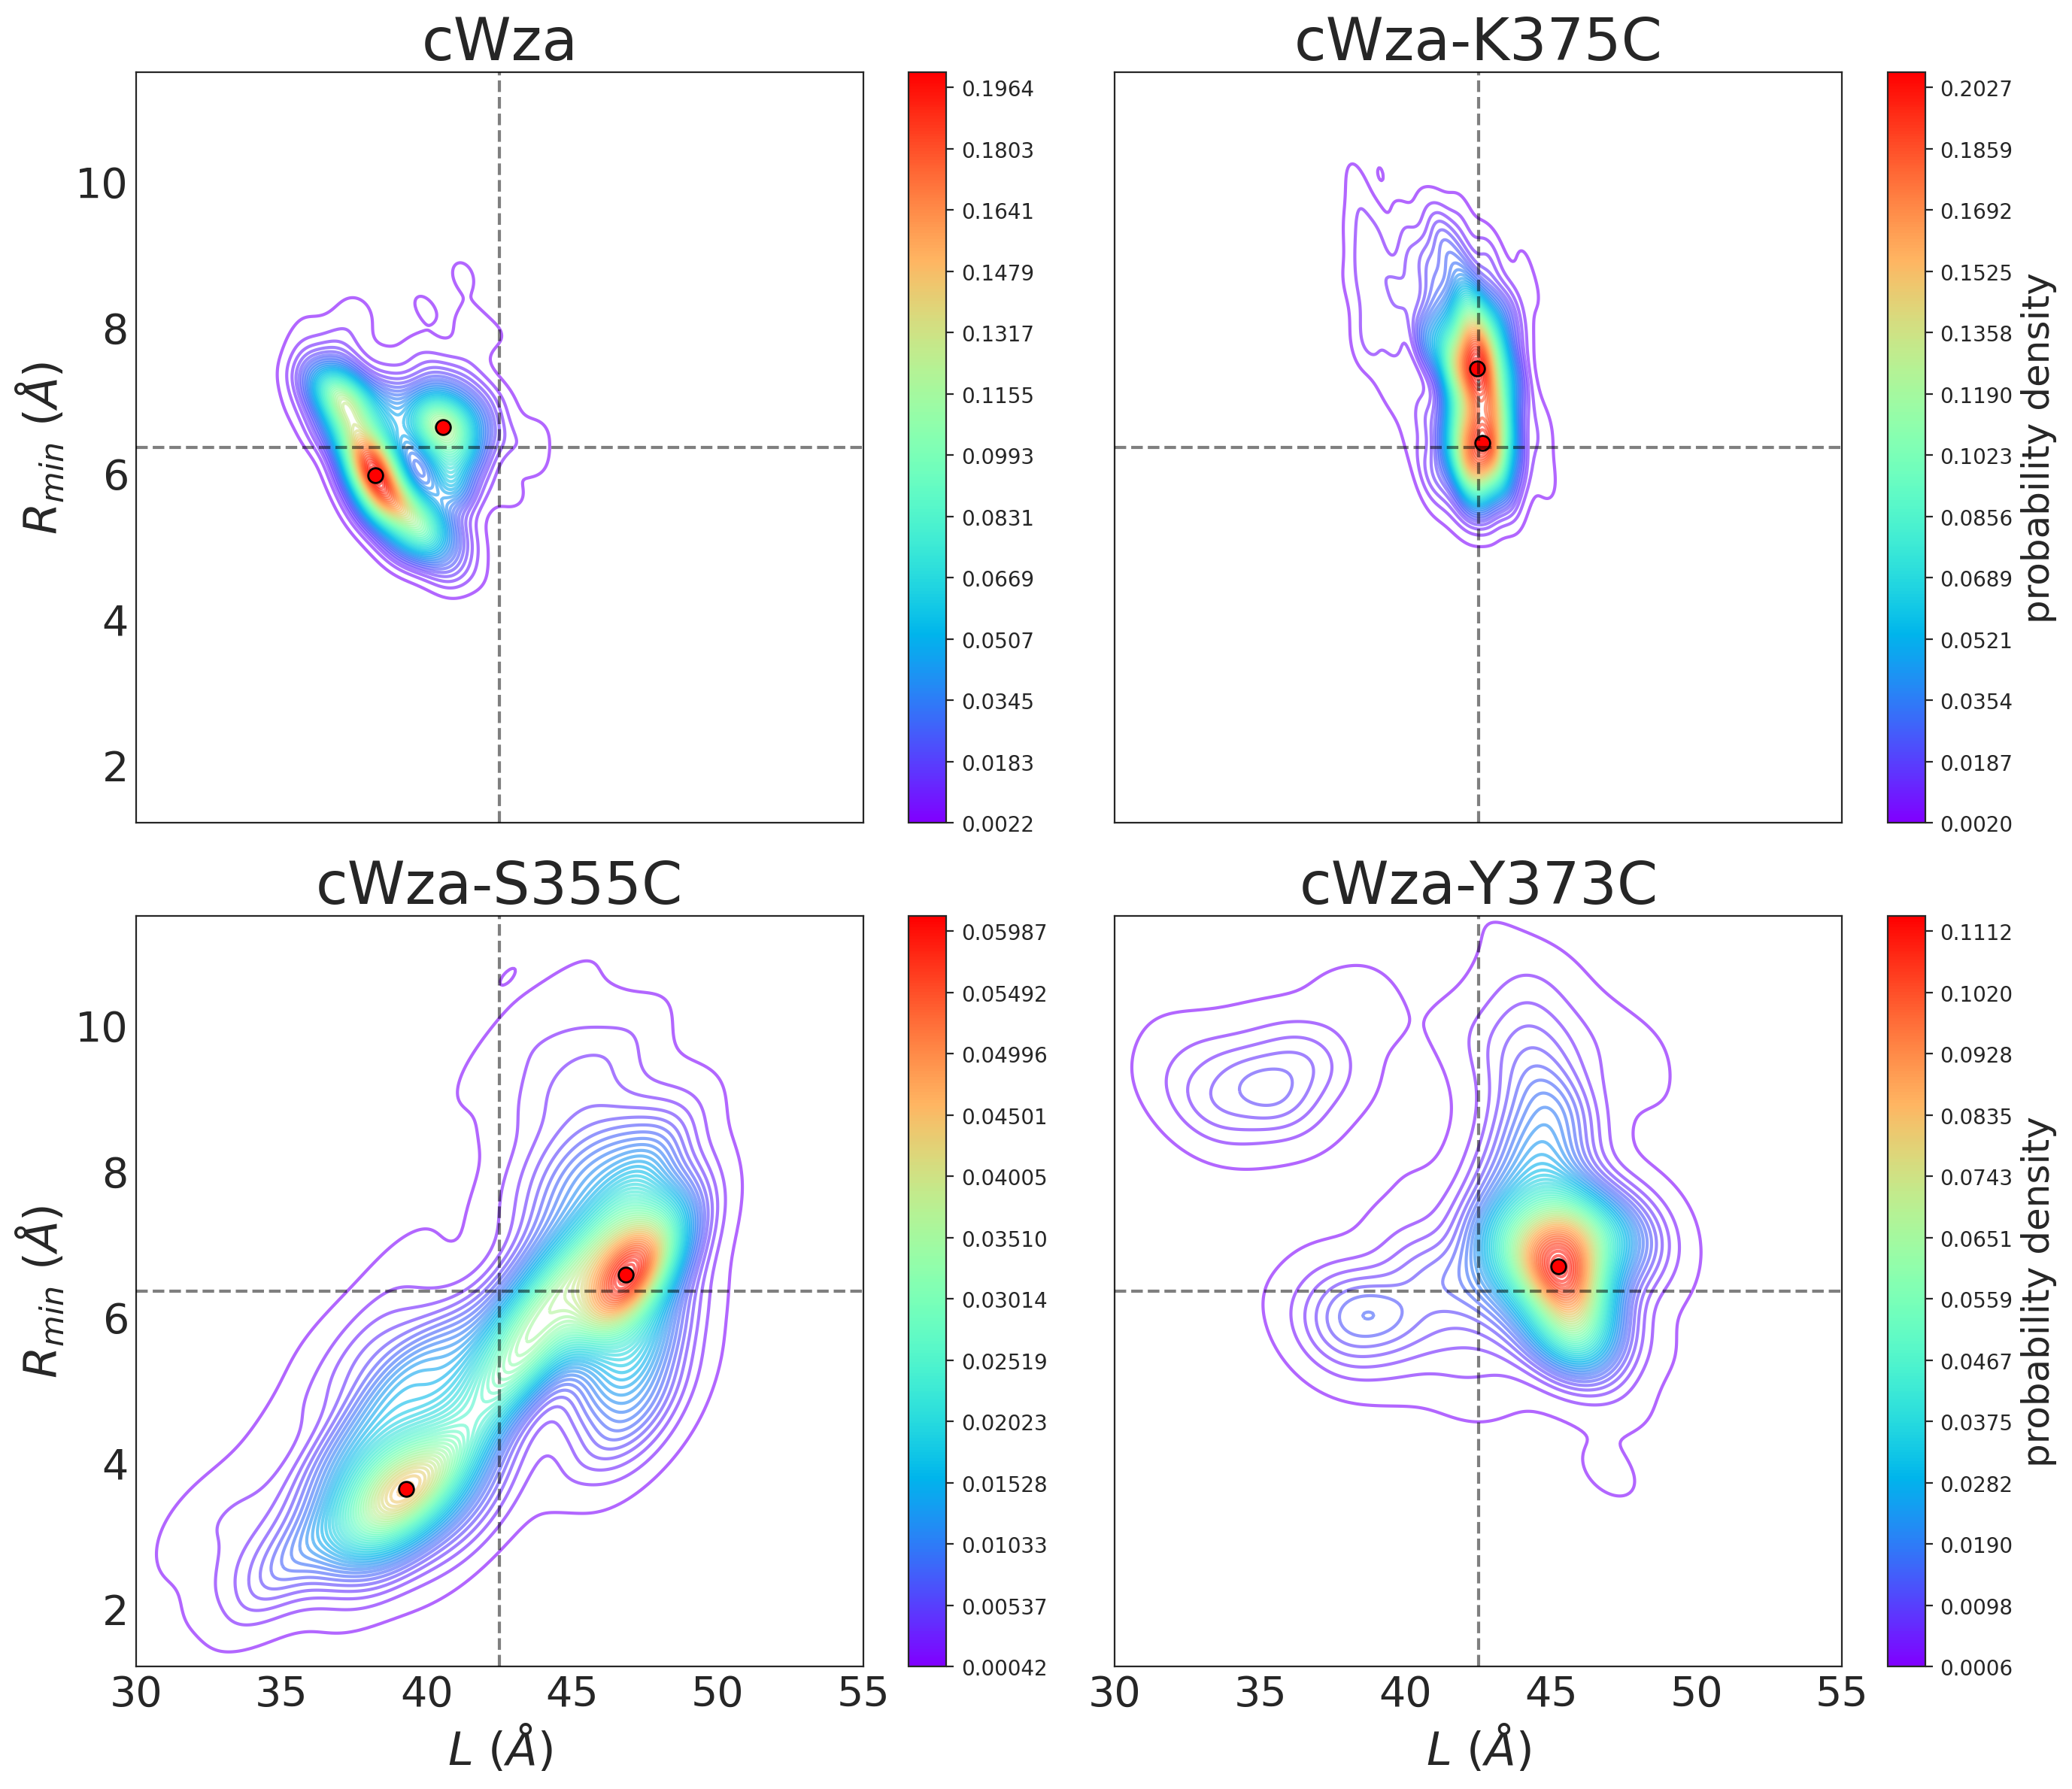

In [12]:
sns.set_style('white')
fig, ax = plt.subplots(2,2, figsize=(14,12),dpi=200,sharex=True,sharey=True)
n_mutants = len(mutant_names)
import matplotlib

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

xlims = (30,55)
ylims = (1.2,11.5)

maxima_mutants = {}

kde_mutants = {}

cmap = plt.get_cmap('rainbow')

for i in range(n_mutants):
    mutant = mutant_names[i]
    key11,key12 = 'vdw metrics','length'
    key21,key22 = 'vdw metrics','min'
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    
    # estimate PDF and set levels for contour plot
    kde = gaussian_kde([X1,X2])
    kde_mutants[mutant] = kde
    Z = kde([X1,X2])
    pdf_max = max(Z)
    pdf_min = min(Z)
    n_contours = 50
    levels = np.linspace(pdf_min, pdf_max, n_contours)
    
    # plot contour lines
    Xc,Yc,Zc = list(density_estimation(X1,X2))
    CS = axes[mutant].contour(Xc,Yc,Zc,levels,cmap=cmap,alpha=0.6)
    
    # colorbar: Continuous
    norm= matplotlib.colors.Normalize(vmin=CS.cvalues.min(), vmax=CS.cvalues.max())
    SM = plt.cm.ScalarMappable(norm=norm, cmap = CS.cmap)
    SM.set_array([])
    CB = fig.colorbar(SM, ticks=CS.levels[::4], ax=axes[mutant])
    
    # find maxima and plot them
    maxima = find_maxima(X1,X2)
    maxima_mutants[mutant] = maxima
    maxima = sorted(maxima, key=itemgetter(1)) # Sort maxima by VdW Rmin 
    for k in range(len(maxima)):
        x,y = maxima[k]
        axes[mutant].scatter(x,y,s=50,marker='o',color='red',edgecolor='black',alpha=1,zorder=10)
        
    # customise plot
    axes[mutant].set_title(mutant, fontsize=28)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=22)
    axes[mutant].set_ylabel(l2,fontsize=22)
    CB.set_label(l3,fontsize=18)
    # reference lines
    axes[mutant].plot(xlims,list(np.ones(2)*np.sum(ylims)/2),color='k',lw=1.5,linestyle="--",alpha=0.5,zorder=20)
    axes[mutant].plot(list(np.ones(2)*np.sum(xlims)/2),ylims,color='k',lw=1.5,linestyle="--",alpha=0.5,zorder=20)

# fig.subplots_adjust(wspace=0.2)
axes[mutant].set_xlim(*xlims)
axes[mutant].set_ylim(*ylims)
plt.tight_layout()
plt.show()

Store peaks coordinates accoridng to cWza-mutant sequence

In [8]:
Conformations_maxima = {}
for mutant in mutant_names:
    # Sort by VdW Rmin
    maxima_mutants[mutant] = sorted(maxima_mutants[mutant], key=itemgetter(1))
    if mutant != 'cWza-Y373C':
        Conformations_maxima[mutant] = {'Narrow': maxima_mutants[mutant][0], 'Wide': maxima_mutants[mutant][1]}
    else:
        Conformations_maxima[mutant] = {'Single': maxima_mutants[mutant][0]}

NEW VERSION

In [9]:
pd.DataFrame(Conformations_maxima,columns=mutant_names,index=['Narrow','Wide','Single'])

cWza  \
Narrow  (38.23668184660026, 5.963437922182342)   
Wide    (40.55376631318942, 6.623566033231066)   
Single                                     NaN   

                                     cWza-K375C  \
Narrow  (42.627566671351275, 6.413905679034267)   
Wide     (42.44531545403704, 7.429559825964146)   
Single                                      NaN   

                                     cWza-S355C  \
Narrow  (39.28609614481061, 3.6349723298522236)   
Wide    (46.839078930591704, 6.579434179867984)   
Single                                      NaN   

                                  cWza-Y373C  
Narrow                                   NaN  
Wide                                     NaN  
Single  (45.252858689855, 6.689163195896889)

ORIGINAL

In [10]:
pd.DataFrame(Conformations_maxima,columns=mutant_names,index=['Narrow','Wide','Single'])

cWza  \
Narrow  (38.23668184660026, 5.963437922182342)   
Wide    (40.55376631318942, 6.623566033231066)   
Single                                     NaN   

                                     cWza-K375C  \
Narrow  (42.627566671351275, 6.413905679034267)   
Wide     (42.44531545403704, 7.429559825964146)   
Single                                      NaN   

                                     cWza-S355C  \
Narrow  (39.28609614481061, 3.6349723298522236)   
Wide    (46.839078930591704, 6.579434179867984)   
Single                                      NaN   

                                  cWza-Y373C  
Narrow                                   NaN  
Wide                                     NaN  
Single  (45.252858689855, 6.689163195896889)

SOURCES

* The two-dimensional _Probability Density Function_ (PDF) is estimated using *Gaussian Kernel Density Estimations (KDE)*. [Reference](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

* Local maxima for the estimated PDF are identified using `peak_local_max`, from `skimage` Python library for Image Processing. See [Reference 1](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max) for the documentation and [Reference 2](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html) for a tutorial. 

# Highlight High Probability (HP) regions

FIGURE VERSION

* Include PDF contour lines
* HP regions coloured accoridng to conformation: `Blue` (Narrow), `Green` (Wide/Single)
* Show raw data with transparent markers

In [36]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

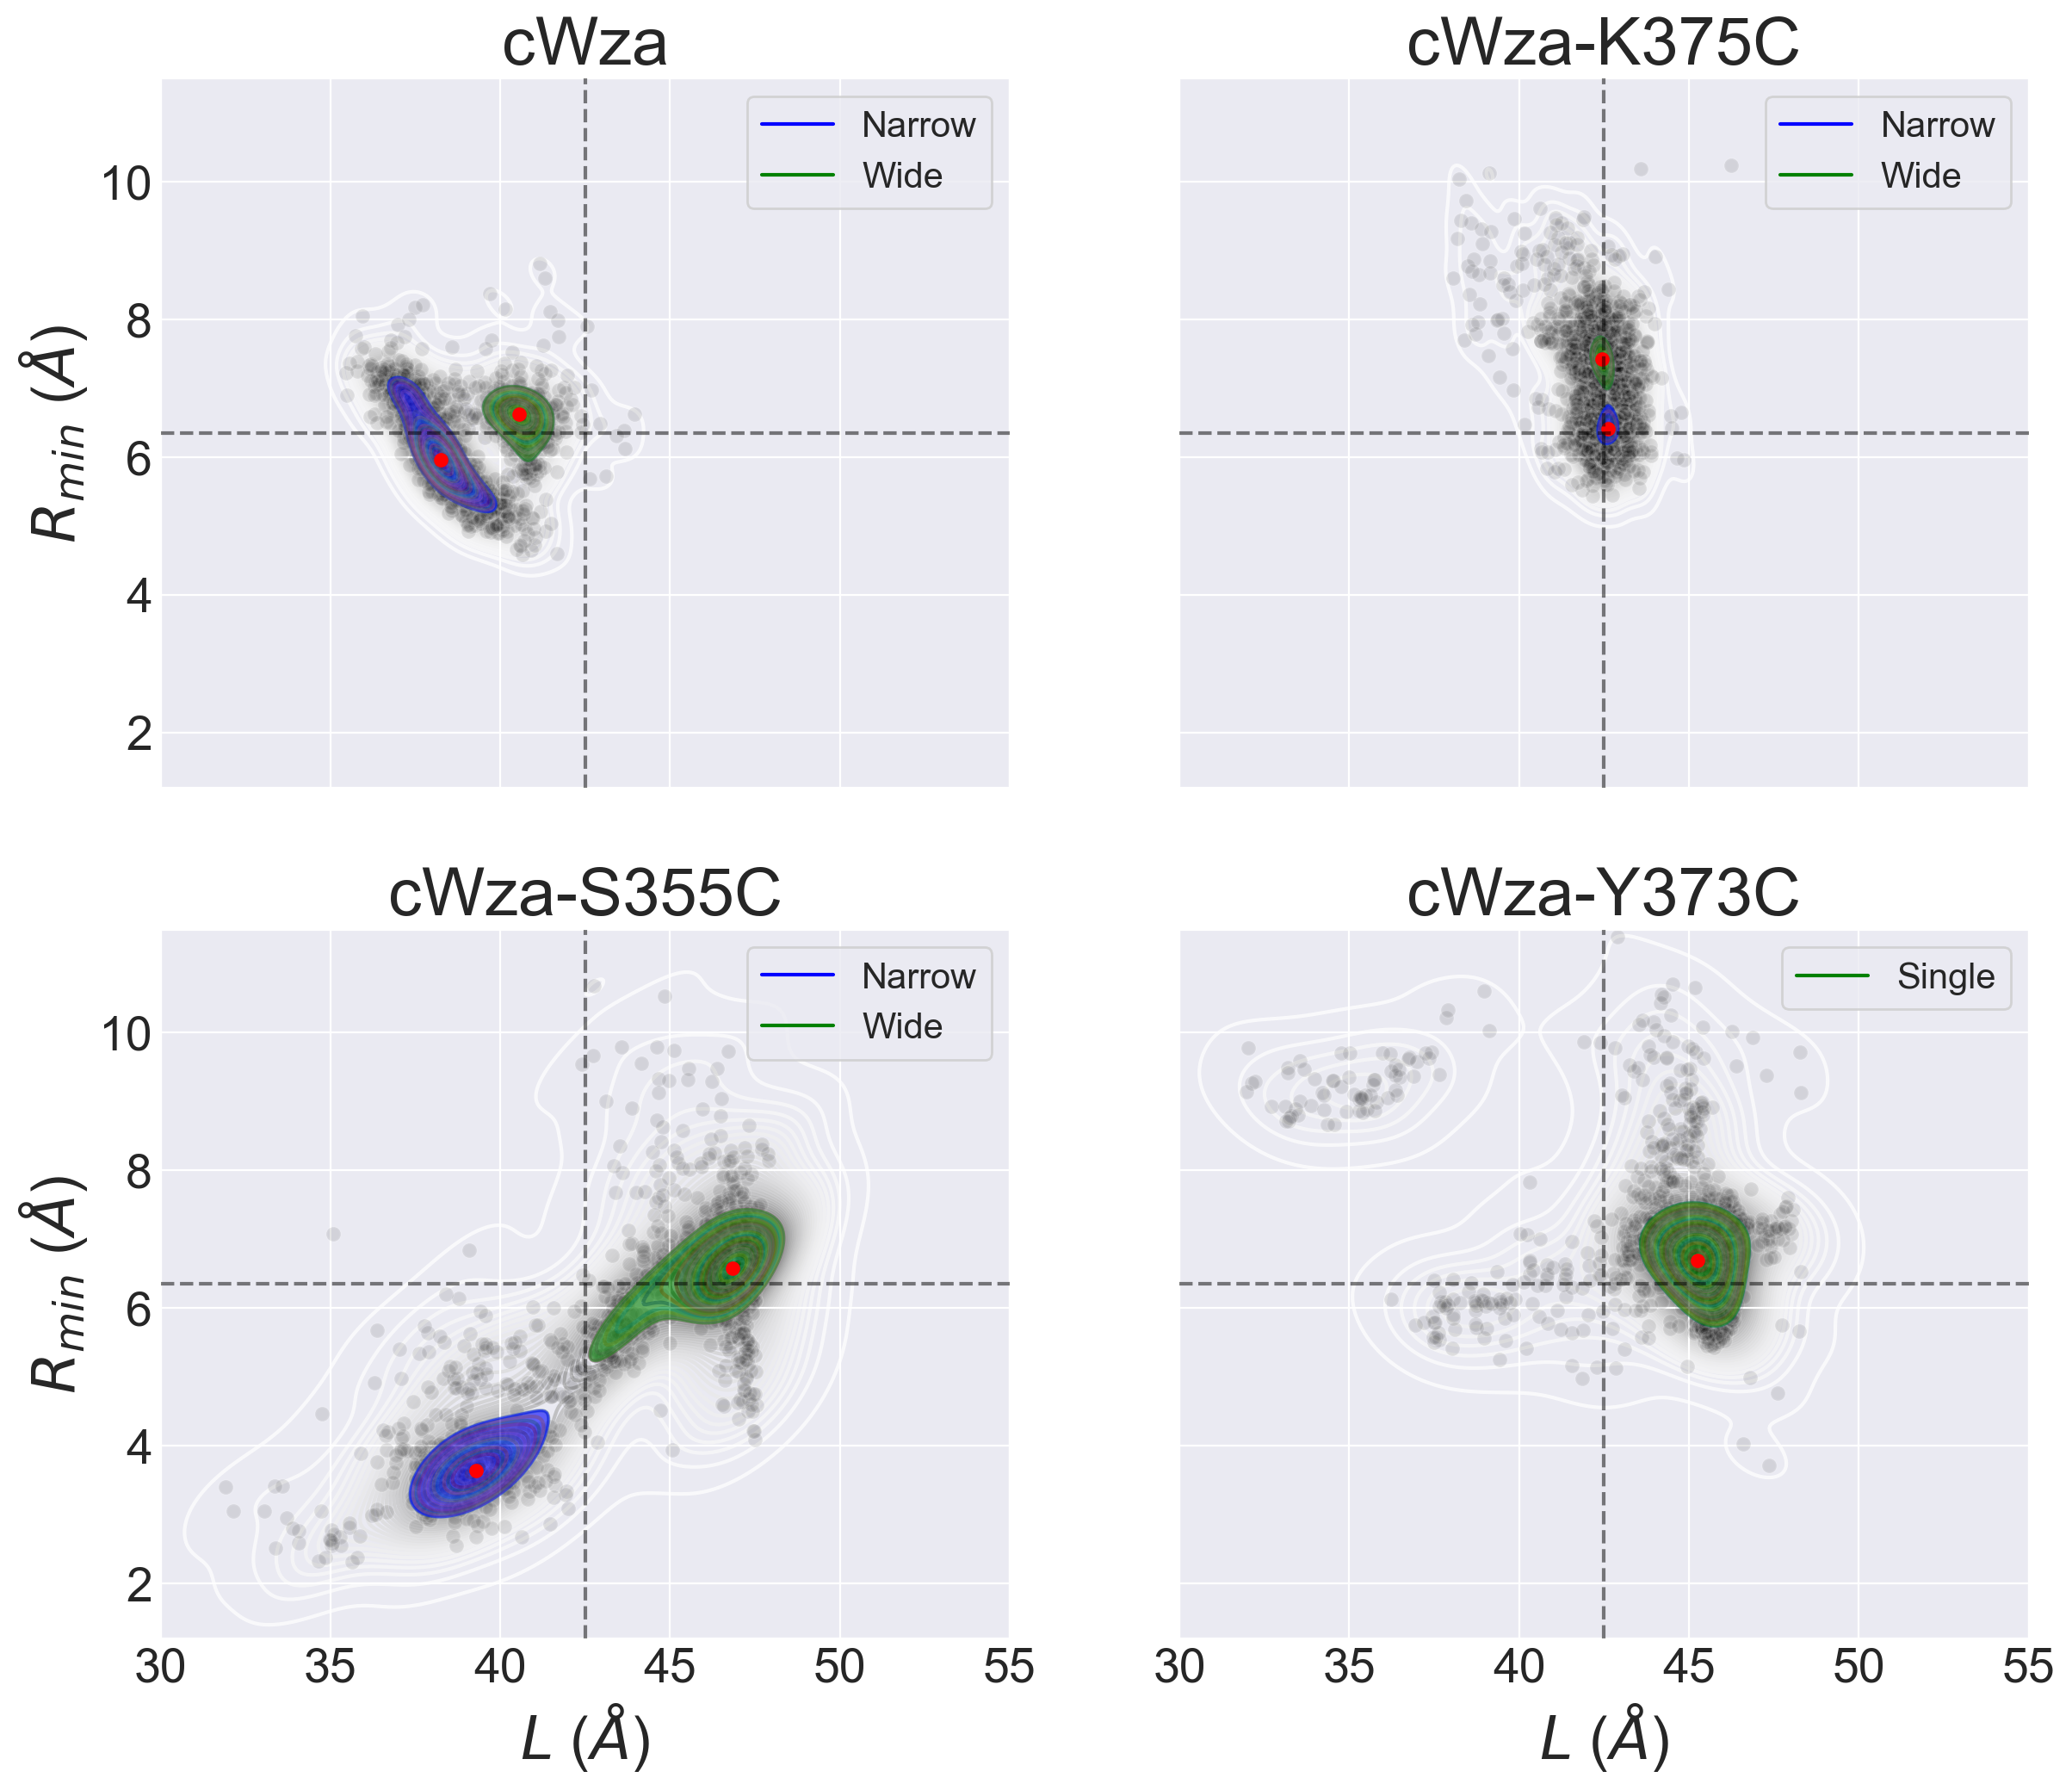

In [40]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=200,sharex=True,sharey=True)

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

Conformations = {
    'cWza':['Narrow', 'Wide'],
    'cWza-K375C':['Narrow', 'Wide'],
    'cWza-S355C':['Narrow', 'Wide'],
    'cWza-Y373C':['Single']
}

Colors = {
    'Narrow': 'blue',
    'Wide': 'green',
    'Single': 'green'
}

xlims = (30,55)
ylims = (1.2,11.5)

Contours_filtred = {}
Contours_mutants = {}
ContoursProb_filtred = {}

ff = 0.5 # filtering factor

for i in range(n_mutants):
    # initialise all dicts
    mutant = mutant_names[i]
    Contours_filtred[mutant] = {}
    Contours_mutants[mutant] = []
    ContoursProb_filtred[mutant] = {}
    
    # extract DB data
    key11,key12 = 'vdw metrics','length'
    key21,key22 = 'vdw metrics','min'
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    
    # estimate PDF and set levels for contour plot
    kde = gaussian_kde([X1,X2])
    Z = kde([X1,X2])
    pdf_max = max(Z)
    pdf_min = min(Z)
    n_contours = 50
    levels = numpy.linspace(pdf_min, pdf_max,n_contours)
    
    # draw PDF contour plots as black transparent background
    axes[mutant].scatter(X1,X2,color='black', edgecolor='white',alpha=0.1)
    Xc,Yc,Zc = list( density_estimation(X1,X2) )
    CS = axes[mutant].contour(Xc,Yc,Zc,levels,cmap='Greys',alpha=0.75,zorder=0)
    
    maxima = maxima_mutants[mutant]
    n_maxima = len(maxima)
    maxima_indices = [(i,list(set(range(n_maxima))-set([i]))) for i in list(set(range(n_maxima)))]

    for n in range(n_maxima):

        # Indeces of main maximum to isolate and remaining maxima
        n0,other_indices = maxima_indices[n]
        Contours_filtred[mutant][n0] = []
        ContoursProb_filtred[mutant][n0] = []
        point0 = Point(maxima[n0])
        other_points = [Point(maxima[n1]) for n1 in other_indices]

        peak0_height = kde(maxima[n0])[0]
        x,y = maxima[n0]
        
        for l in range(len(CS.allsegs)):
            prob = CS.levels[l]
            for k in range(len(CS.allsegs[l])):
                
                # Extract contour line coordinates
                CS_coords = CS.allsegs[l][k]
                Contours_mutants[mutant].append(CS_coords)
                
                # Turn contour line into Polygon
                polygon = Polygon(CS_coords)
                
                # Check if maximum within contour line
                if polygon.contains(point0):
                    if all([not polygon.contains(point) for point in other_points]):
                        if prob > ff*peak0_height:
                            Contours_filtred[mutant][n0].append(CS_coords)
                            ContoursProb_filtred[mutant][n0].append(prob)
                            CS_coords = CS_coords.T
                            axes[mutant].plot(CS_coords[0],CS_coords[1],alpha=0.2,zorder=5)
                                
    # customise plot
    axes[mutant].set_title(mutant, fontsize=28)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=25)
    axes[mutant].set_ylabel(l2,fontsize=25)
    
    # fill regions of High Probability (HP) and show maxima
    for n in range(n_maxima):
        x,y = maxima_mutants[mutant][n]
        axes[mutant].scatter(x,y,s=25,color='red',zorder=10)
        X,Y = Contours_filtred[mutant][n][0].T
        if max(ContoursProb_filtred[mutant][n]) > 0.02:
            c = Colors[Conformations[mutant][n]]
            axes[mutant].fill(X,Y,color=c,alpha=0.6)
            axes[mutant].plot([],[],label=Conformations[mutant][n],color=c)
    
    axes[mutant].legend(loc='best',fontsize=15)
    
    axes[mutant].plot(xlims,list(np.ones(2)*np.sum(ylims)/2),color='k',lw=1.5,linestyle="--",alpha=0.5,zorder=20)
    axes[mutant].plot(list(np.ones(2)*np.sum(xlims)/2),ylims,color='k',lw=1.5,linestyle="--",alpha=0.5,zorder=20)

# fig.subplots_adjust(wspace=0.2)
axes[mutant].set_xlim(*xlims)
axes[mutant].set_ylim(*ylims)
    
# plt.tight_layout()
plt.show()

FIGURE VERSION

* Include PDF contour lines
* HP regions coloured accoridng to conformation: `Blue` (Narrow), `Green` (Wide/Single)
* Display in the legend box the percentage of models falling within each HP region

> <span style="color:red">_NOTE_</span> The execution of the cells do not only produce this figure version but simulataneously model IDs are filtered according to `mutant` and `conformation` identities.

In [38]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

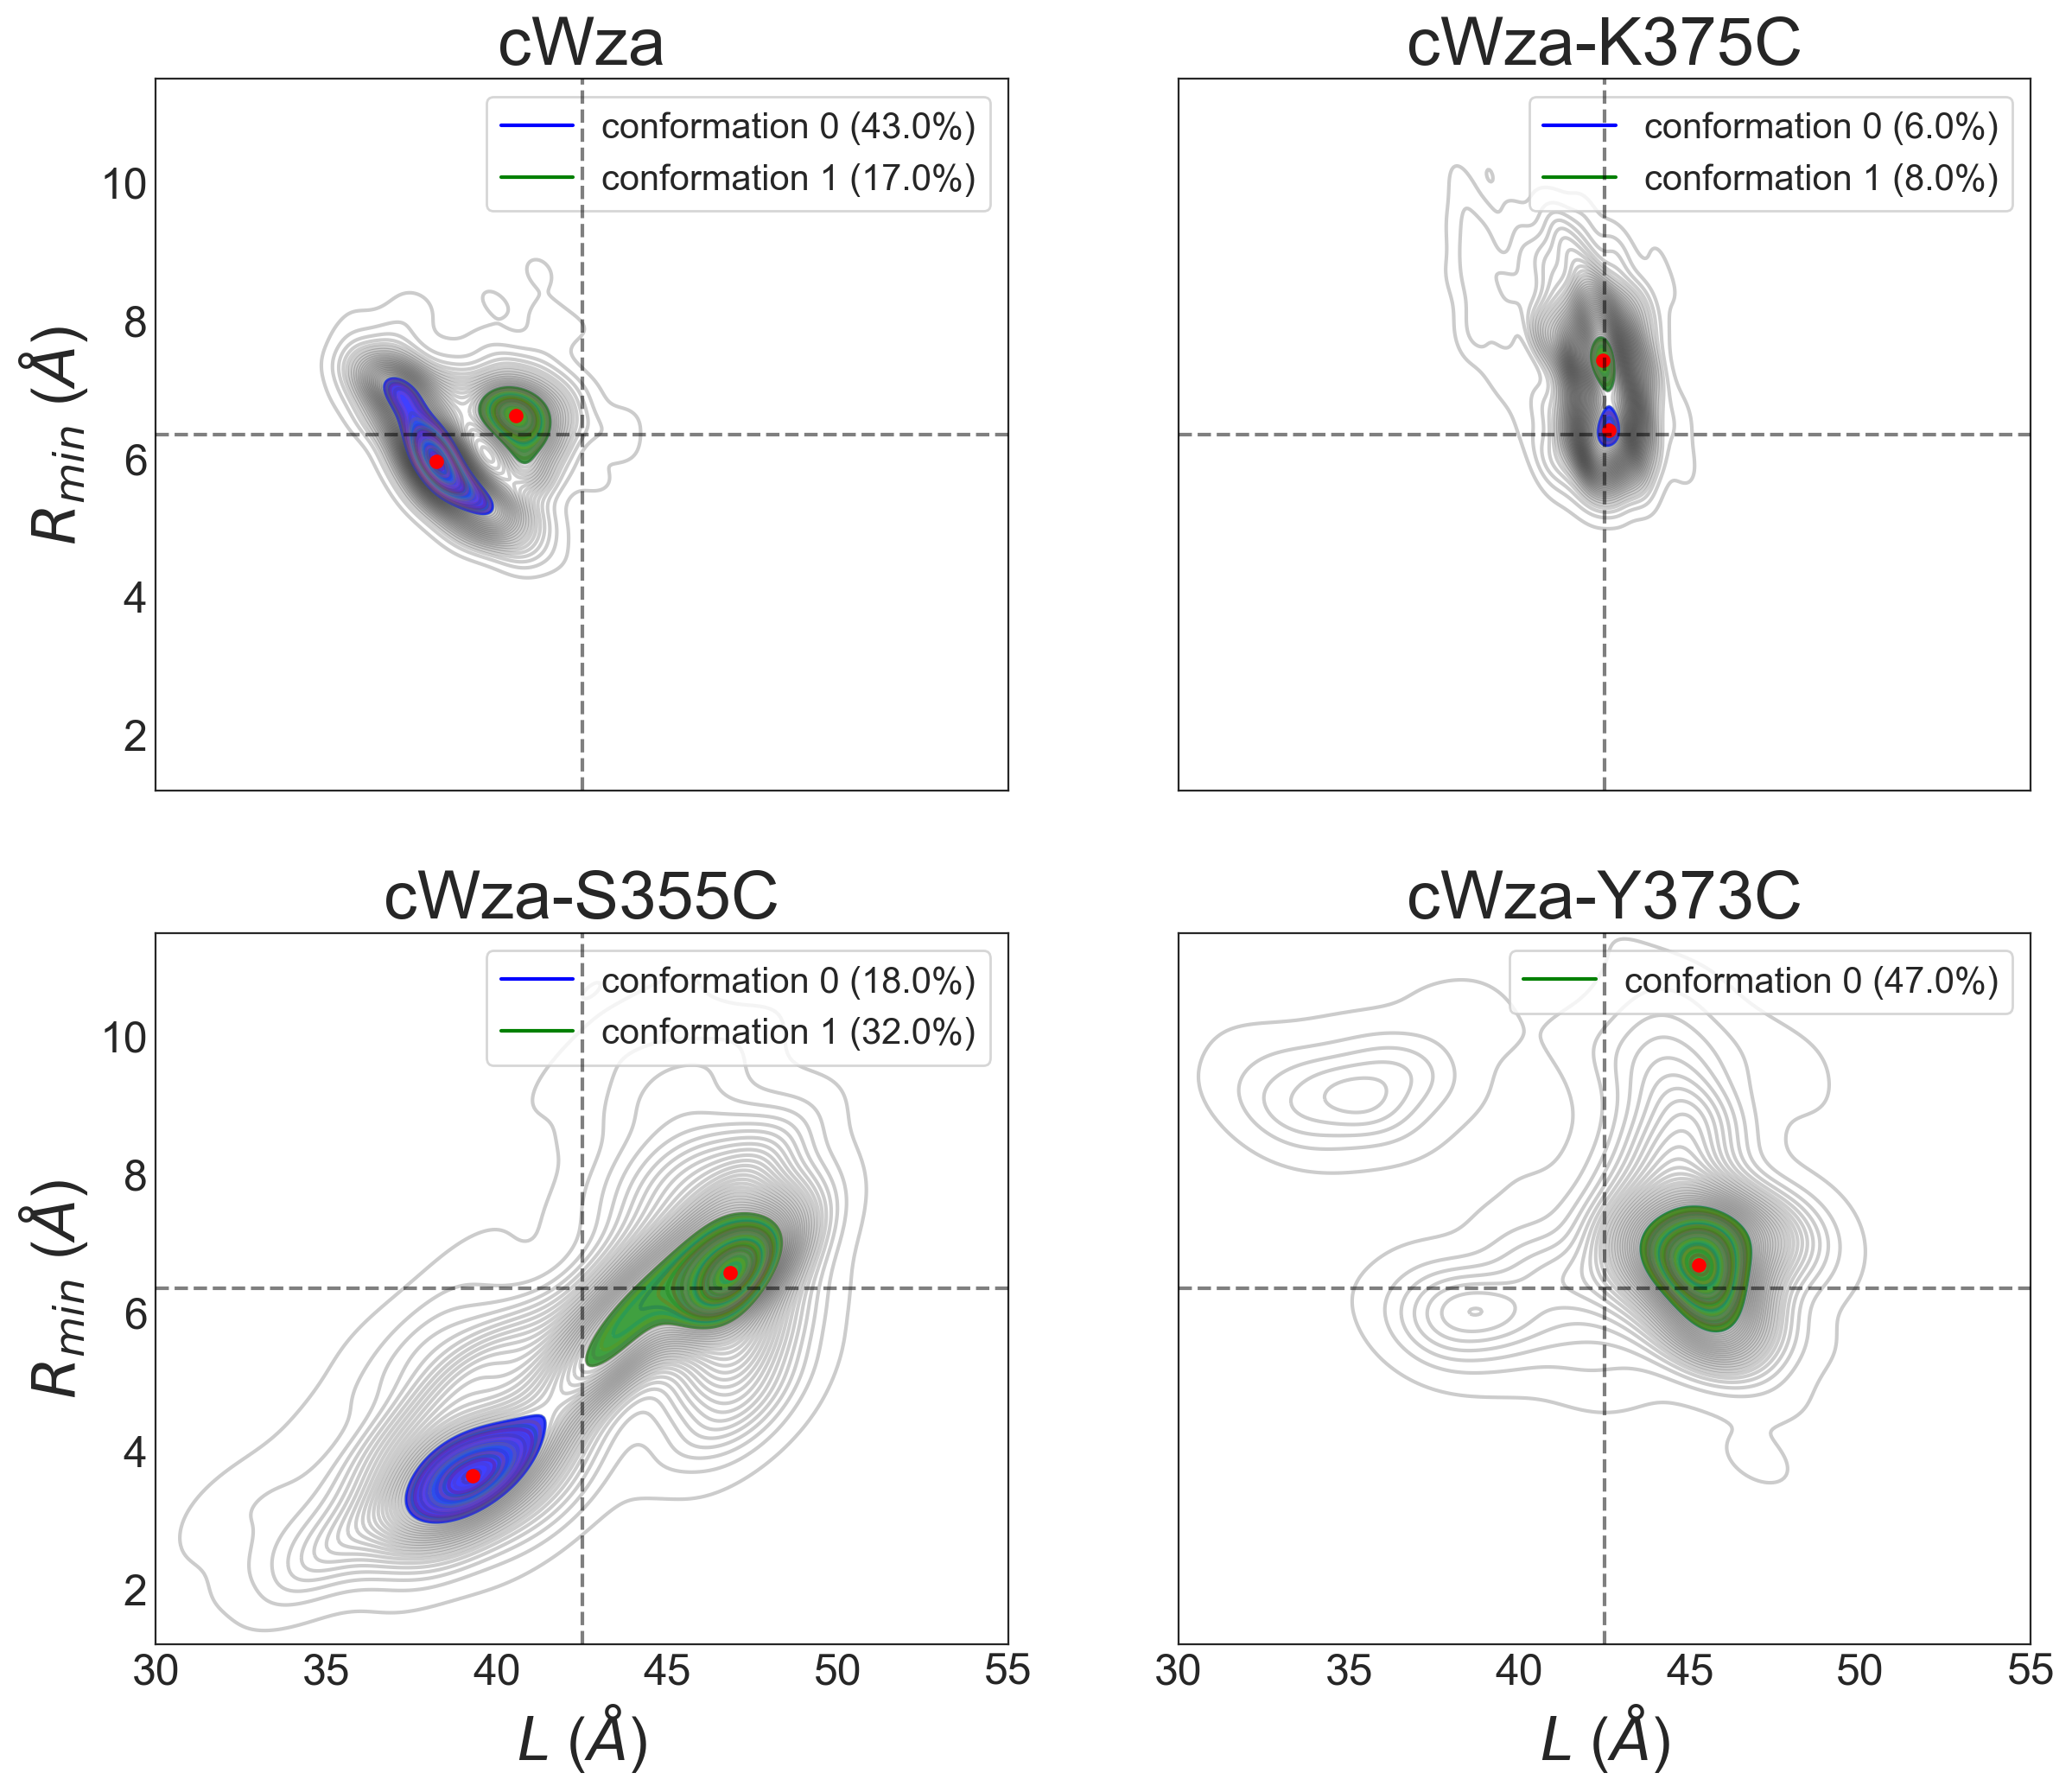

In [46]:
sns.set_style("white")
fig, ax = plt.subplots(2,2, figsize=(14,12),dpi=200,sharex=True,sharey=True)

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

Conformations = {
    'cWza':['Narrow', 'Wide'],
    'cWza-K375C':['Narrow', 'Wide'],
    'cWza-S355C':['Narrow', 'Wide'],
    'cWza-Y373C':['Single']
}

Colors = {
    'Narrow': 'blue',
    'Wide': 'green',
    'Single': 'green'
}

xlims = (30,55)
ylims = (1.2,11.5)

Contours_filtred = {}
Contours_mutants = {}
ContoursProb_filtred = {}
Filtered_Indices = {}
Filtered_IDs = {}

ff = 0.5 # filtering factor

for i in range(n_mutants):
    # initialise datasets
    mutant = mutant_names[i]
    Contours_filtred[mutant] = {}
    Contours_mutants[mutant] = []
    ContoursProb_filtred[mutant] = {}
    Filtered_IDs[mutant] = {}
    IDs = [id for id in S_mutants[mutant].keys()]
    
    # extract DB data
    key11,key12 = 'vdw metrics','length'
    key21,key22 = 'vdw metrics','min'
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    
    # stuff for filtering models IDs
    Filtered_Indices[mutant] = {}
    N_models = len(S_mutants[mutant].keys())
    Points = [Point(X1[n],X2[n]) for n in range(N_models)]
    
    # estimate PDF and set levels for contour plot
    kde = gaussian_kde([X1,X2])
    Z = kde([X1,X2])
    pdf_max = max(Z)
    pdf_min = min(Z)
    n_contours = 50
    levels = numpy.linspace(pdf_min, pdf_max,n_contours)
    
    # draw all contour plots as black transparent background
    Xc,Yc,Zc = list( density_estimation(X1,X2) )
    CS = axes[mutant].contour(Xc,Yc,Zc,levels,colors='k',alpha=0.2,zorder=0)
    
    maxima = maxima_mutants[mutant]
    n_maxima = len(maxima)
    maxima_indices = [(i,list(set(range(n_maxima))-set([i]))) for i in list(set(range(n_maxima)))]
        
    for n in range(n_maxima):

        # indeces of main maximum to isolate and remaining maxima
        n0,other_indices = maxima_indices[n]
        Contours_filtred[mutant][n0] = []
        ContoursProb_filtred[mutant][n0] = []
        point0 = Point(maxima[n0])
        other_points = [Point(maxima[n1]) for n1 in other_indices]
        
        peak0_height = kde(maxima[n0])[0]
        x,y = maxima[n0]

        for l in range(len(CS.allsegs)):
            prob = CS.levels[l]
            for k in range(len(CS.allsegs[l])):
                
                # extract contour line coordinates
                CS_coords = CS.allsegs[l][k]
                Contours_mutants[mutant].append(CS_coords)
                
                # turn contour line into Polygon
                polygon = Polygon(CS_coords)
                
                # check if maximum within contour line
                if polygon.contains(point0):
                    if all([not polygon.contains(point) for point in other_points]):
                        
                        # filter out contour lines with PDF values below ff*peak_value
                        if prob > ff*peak0_height:
                            Contours_filtred[mutant][n0].append(CS_coords)
                            ContoursProb_filtred[mutant][n0].append(prob)
                            CS_coords = CS_coords.T
                            axes[mutant].plot(CS_coords[0],CS_coords[1],alpha=0.2,zorder=5)
                            
    # customise plot
    axes[mutant].set_title(mutant, fontsize=28)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=18)
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=25)
    axes[mutant].set_ylabel(l2,fontsize=25)
    
    # fill regions of HP and show maxima
    for n in range(n_maxima):
        
        # PDF maximum location
        x,y = maxima_mutants[mutant][n]
        axes[mutant].scatter(x,y,s=25,color='red',zorder=10)
        X,Y = Contours_filtred[mutant][n][0].T
        
        # count models
        polygon = Polygon(Contours_filtred[mutant][n][0])
        Filtered_Indices[mutant][n] = [k for k in range(N_models) if polygon.contains(Points[k])]
        
        # filter models IDs
        Filtered_IDs[mutant][n] = itemgetter(*Filtered_Indices[mutant][n])(IDs)
        
        # fill contour lines with PDF value above threshold
        threshold = 0.02
        if max(ContoursProb_filtred[mutant][n]) > threshold:
            c = Colors[Conformations[mutant][n]]
            axes[mutant].fill(X,Y,color=c,alpha=0.75)
            C_name = Conformations[mutant][n] # conformation name
            N_models_C = len(Filtered_Indices[mutant][n]) # number of models
            Percentage = numpy.floor(100*(N_models_C/N_models)) # percentage
            
            # Add legend box
#             axes[mutant].plot([],[],label=C_name+' ('+str(Percentage)+'%)',color=c)
            axes[mutant].plot([],[],label='conformation '+str(n)+' ('+str(Percentage)+'%)',color=c)
    
    axes[mutant].legend(loc='best',fontsize=15)
    # reference lines
    axes[mutant].plot(xlims,list(np.ones(2)*np.sum(ylims)/2),color='k',lw=1.5,linestyle="--",alpha=0.5,zorder=20)
    axes[mutant].plot(list(np.ones(2)*np.sum(xlims)/2),ylims,color='k',lw=1.5,linestyle="--",alpha=0.5,zorder=20)

# fig.subplots_adjust(wspace=0.2)
axes[mutant].set_xlim(*xlims)
axes[mutant].set_ylim(*ylims)
# plt.tight_layout()
plt.show()

Save filtered IDs that have been labelled 

```python
folder = 'data'
filename_output = 'mutants_docking_filtered_ids_labelled.json'
path   = os.path.join(folder, filename_output)

with open(path, 'w') as fp:
    json.dump(Filtered_IDs, fp, indent=4)
```

# Verify models fall within HP regions

# Label PDBs according to mutant and conformation identity

Mapping between `id`s and `PDB` names will be useful for classification of Euler angles and peptide-peptide interaction data accoridng to mutant and conformation labells.

We do this mapping using the steps below.

FIRST, initialise raw database session

In [20]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_geometry_interactions_db import Tags, Base

folder = 'data'
dbfile = 'mutants_docked_geometry-interactions.db' # database
path   = os.path.join(folder, dbfile)

engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

Load labelled dict of IDs data

In [34]:
folder = 'data'
filename_input = "mutants_docking_filtered_ids_labelled.json"
path   = os.path.join(folder, filename_input)

with open(path, 'r') as fp:
    Filtered_IDs = json.load(fp)

Parse query to DB for PDB names according to ID

In [27]:
Filtered_PDBs = {}

for i in range(n_mutants):
    mutant = mutant_names[i]
    n_maxima = len(maxima_mutants[mutant])
    Filtered_PDBs[mutant] = {}
    
    for n in range(n_maxima):
        PDB_names = session.query(
                Tags.pdb_name).filter_by(
                mutant = mutant).filter(
                Tags.id.in_(Filtered_IDs[mutant][str(n)])).all()
        PDB_names = [x[0] for x in PDB_names]
        Filtered_PDBs[mutant][n] = PDB_names

Youy can display the data to have an idea of what it looks like

In [36]:
Filtered_PDBs

{'cWza': {0: ['refined1_0001_INPUT_0004_ignorechain.pdb',
   'refined1_0001_INPUT_0013_ignorechain.pdb',
   'refined1_0001_INPUT_0001_ignorechain.pdb',
   'refined1_0001_INPUT_0003_ignorechain.pdb',
   'refined1_0001_INPUT_0002_ignorechain.pdb',
   'refined1_0001_INPUT_0021_ignorechain.pdb',
   'refined1_0001_INPUT_0028_ignorechain.pdb',
   'refined1_0001_INPUT_0024_ignorechain.pdb',
   'refined1_0001_INPUT_0027_ignorechain.pdb',
   'refined1_0001_INPUT_0029_ignorechain.pdb',
   'refined1_0001_INPUT_0023_ignorechain.pdb',
   'refined1_0001_INPUT_0032_ignorechain.pdb',
   'refined1_0001_INPUT_0035_ignorechain.pdb',
   'refined1_0001_INPUT_0034_ignorechain.pdb',
   'refined1_0001_INPUT_0033_ignorechain.pdb',
   'refined1_0001_INPUT_0030_ignorechain.pdb',
   'refined1_0001_INPUT_0038_ignorechain.pdb',
   'refined1_0001_INPUT_0037_ignorechain.pdb',
   'refined1_0001_INPUT_0031_ignorechain.pdb',
   'refined1_0001_INPUT_0039_ignorechain.pdb',
   'refined1_0001_INPUT_0026_ignorechain.pdb',
  

Save the data

```python
folder = 'data'
filename_output = "mutants_docking_pdbnames_labelled.json"
path = os.path.join(folder, filename_output)

with open(path, 'w') as fp:
    json.dump(Filtered_PDBs, fp, indent=4)
```

# <span style="color:red">TO-DO's</span>

* Add cells to generate plot with filtered data points to verify models fall within HP regions (section above)
